# Imagery statistics


To obtain more information about an image before saving it or if we want to perform various analyses, we can use EO-TDL statistics. Statistics returns aggregated statistical values of satellite data instead of entire images.


Uncomment the following line to install eotdl if needed.

In [ ]:
#!pip install eotdl

First, let's define the time period and the location we want to use in the analysis.

In [2]:
dates = ("2023-01-01", "2024-01-01")
bounding_box = (15.21872446127822, 46.23652112017396, 15.278209373750574, 46.27288297628169)

We select EO-TDL's Sentinel-2 Level-2A data collection, get default parameters and set the maximum cloud coverage and the aggregation interval (ISO 8601 format).


In [3]:
from eotdl.access import (
    DATA_COLLECTION_ID,
    get_default_parameters
)

parameters = get_default_parameters(DATA_COLLECTION_ID.SENTINEL_2_L2A)
parameters.MAX_CLOUD_COVERAGE = 0.2
parameters.AGGREGATION_INTERVAL = "P2W"

We also need to define the evalscript, in which we specify what value each pixel will represent. Based on this, the statistics will be calculated. In our case, the pixel will represent the NDVI value, which is calculated from the red and near-infrared spectral bands.

In [4]:
evalscript = """ 
//VERSION=3

function setup() {
  return {
    input: [
      {
        bands: [
          "B04",
          "B08",
          "dataMask"
        ]
      }
    ],
    output: [
      {
        id: "ndvi",
        bands: 1
      },
      {
        id: "dataMask",
        bands: 1
      }
    ]
  }
}

function evaluatePixel(sample) {
    let ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);
  
    return {
      ndvi: [ndvi],
      dataMask: [sample.dataMask]
    };
}
"""

We now request statistical data over the defined time and location, and store the results in a pandas DataFrame.

In [6]:
from eotdl.access import (
    get_statistics,
)

df = get_statistics(dates, bounding_box, parameters, evalscript)
df

,interval_from,interval_to,ndvi_B0_min,ndvi_B0_max,ndvi_B0_mean,ndvi_B0_stDev,ndvi_B0_sampleCount,ndvi_B0_noDataCount
0,2023-01-29,2023-02-12,-0.304725,1.000000,0.354767,0.217092,185085,0
1,2023-02-12,2023-02-26,-0.134443,1.000000,0.452769,0.170749,185085,0
2,2023-03-12,2023-03-26,-0.160920,0.896398,0.510750,0.210291,185085,0
3,2023-04-23,2023-05-07,-0.334586,0.930391,0.612180,0.244231,185085,0
4,2023-05-21,2023-06-04,-0.198818,0.917716,0.612030,0.238982,185085,0
5,2023-06-04,2023-06-18,-0.093023,0.888085,0.450685,0.243900,185085,0
6,2023-06-18,2023-07-02,-0.321828,1.000000,0.640875,0.234965,185085,0
7,2023-07-02,2023-07-16,-0.145189,0.956168,0.673378,0.232812,185085,0
8,2023-07-16,2023-07-30,-0.175010,0.933466,0.671726,0.233305,185085,0
9,2023-08-13,2023-08-27,-0.071314,0.900580,0.622894,0.214556,185085,0


We visualize the mean NDVI values over time, along with standard deviation as a shaded band.

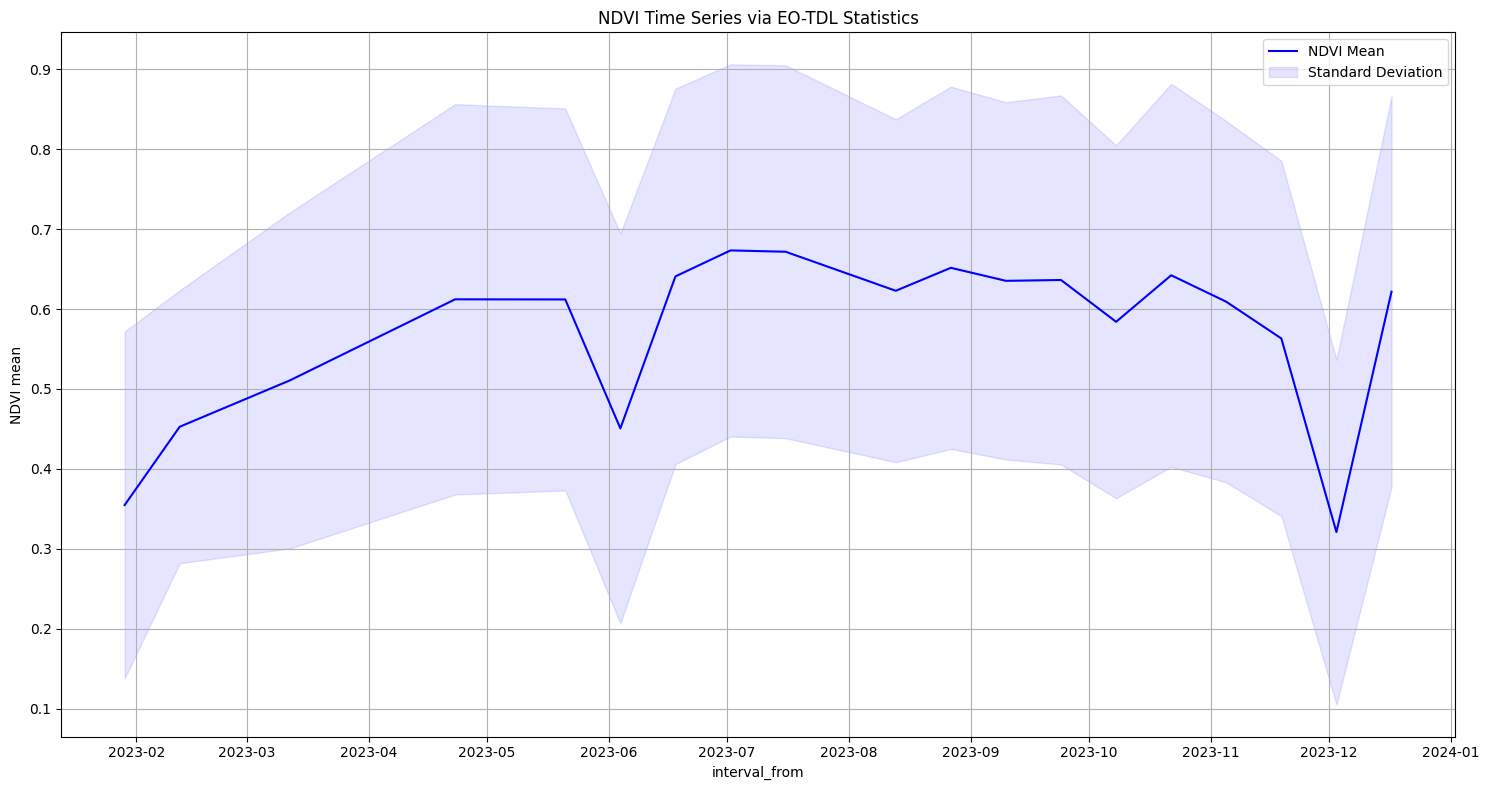

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 8))
ax.set_title("NDVI Time Series via EO-TDL Statistics")
ax.set_ylabel("NDVI mean")
ax.set_xlabel("Date")

# Plot NDVI mean
df.plot(ax=ax, x="interval_from", y="ndvi_B0_mean", color="blue", label="NDVI Mean")

# Fill between +/- 1 standard deviation
ax.fill_between(
    df.interval_from.values,
    df["ndvi_B0_mean"] - df["ndvi_B0_stDev"],
    df["ndvi_B0_mean"] + df["ndvi_B0_stDev"],
    color="blue",
    alpha=0.1,
    label="Standard Deviation"
)

ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This NDVI time series analysis, using EO-TDL Statistics, offers a clear view of vegetation trends in a selected region. NDVI is a reliable indicator of vegetation health, and EO-TDL's cloud-aware, interval-based approach allows for clean, interpretable time-series generation from remote sensing data.